In [1]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle


import sys, os
# sys.path.append(os.path.abspath('..'))
# from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

plt.rcParams['lines.linewidth'] = 0.5 

mpl.rcParams.update({'font.size': 4, 'lines.linewidth': 0.5, 'figure.dpi': 150})


In [2]:
pair = 'BTC_USDT'
timeframe = '4h'

exchange = 'binance'
odf = pd.read_json(f'../../freq-user-data/data/{exchange}/{pair}-{timeframe}.json'
# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

print(odf.shape)
odf.tail(4)

(12676, 6)


,timestamp,open,high,low,close,volume
dtime,,,,,,
2023-06-01 20:00:00,1685649600000,26862.68,26942.98,26713.34,26817.93,3659.35611
2023-06-02 00:00:00,1685664000000,26817.93,27017.00,26505.00,27000.00,7016.04160
2023-06-02 04:00:00,1685678400000,27000.01,27213.00,26949.40,27049.65,6856.64454
2023-06-02 08:00:00,1685692800000,27049.65,27183.07,27049.38,27130.75,3577.11000


In [116]:
ldf = odf[['open', 'high', 'low', 'close']].apply(np.log).copy()
ldf.head(4)

,open,high,low,close
dtime,,,,
2017-08-17 04:00:00,8.357372,8.377929,8.357334,8.377929
2017-08-17 08:00:00,8.374089,8.408581,8.374089,8.395545
2017-08-17 12:00:00,8.397522,8.408581,8.374112,8.378469
2017-08-17 16:00:00,8.378467,8.379043,8.343016,8.372221


In [38]:
# ldf.rolling(fuper).max().shift(-fuper)
np.linspace(0, 1, 6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [117]:
fuper = 6 * 2

ldf['fu_high'] = ldf.high.rolling(fuper).max().shift(-fuper)
ldf['fu_low'] = ldf.low.rolling(fuper).min().shift(-fuper)
ldf['fu_high_pct'] = ldf.fu_high - ldf.close
ldf['fu_low_pct'] = ldf.fu_low - ldf.close

q = np.linspace(0, 1, 6)

# ldf
ldf['cat_low_pct'] = pd.qcut(ldf.fu_low_pct, q, precision=3)
ldf['cat_high_pct'] = pd.qcut(ldf.fu_high_pct, q, precision=3)
# ldf.cat_high_pct.value_counts()
ldf['cat_low_rbound'] = ldf['cat_low_pct'].apply(lambda x: x.right)
ldf['cat_high_rbound'] = ldf['cat_high_pct'].apply(lambda x: x.right)
# ldf.cat_high_pct.apply(lambda x: print(x.right))
# ldf['cat_fu'] = ldf.apply(lambda x: '{x.right}')
ldf = ldf.dropna()
ldf['cat_fu'] = ldf.cat_low_rbound.astype(str) + "__" + ldf.cat_high_rbound.astype(str)
ldf['cat_fu'].value_counts()
# pd.qcut(ldf.fu_high, np.linspace(0, 1, 6))

cat_fu
0.00092__0.353       1045
-0.0641__0.00982      947
-0.0357__0.00982      731
0.00092__0.0614       651
-0.00987__0.0614      637
-0.0357__0.0203       619
-0.0205__0.035        614
-0.00987__0.353       581
-0.0641__0.0203       562
-0.00987__0.035       558
-0.0205__0.0203       551
-0.0357__0.035        514
-0.0205__0.00982      495
-0.0205__0.0614       484
-0.00987__0.0203      472
0.00092__0.035        433
-0.0641__0.035        413
-0.0357__0.0614       412
-0.0205__0.353        388
-0.0641__0.0614       349
0.00092__0.0203       329
-0.00987__0.00982     285
-0.0641__0.353        262
-0.0357__0.353        257
0.00092__0.00982       75
Name: count, dtype: int64

<Axes: xlabel='dtime'>

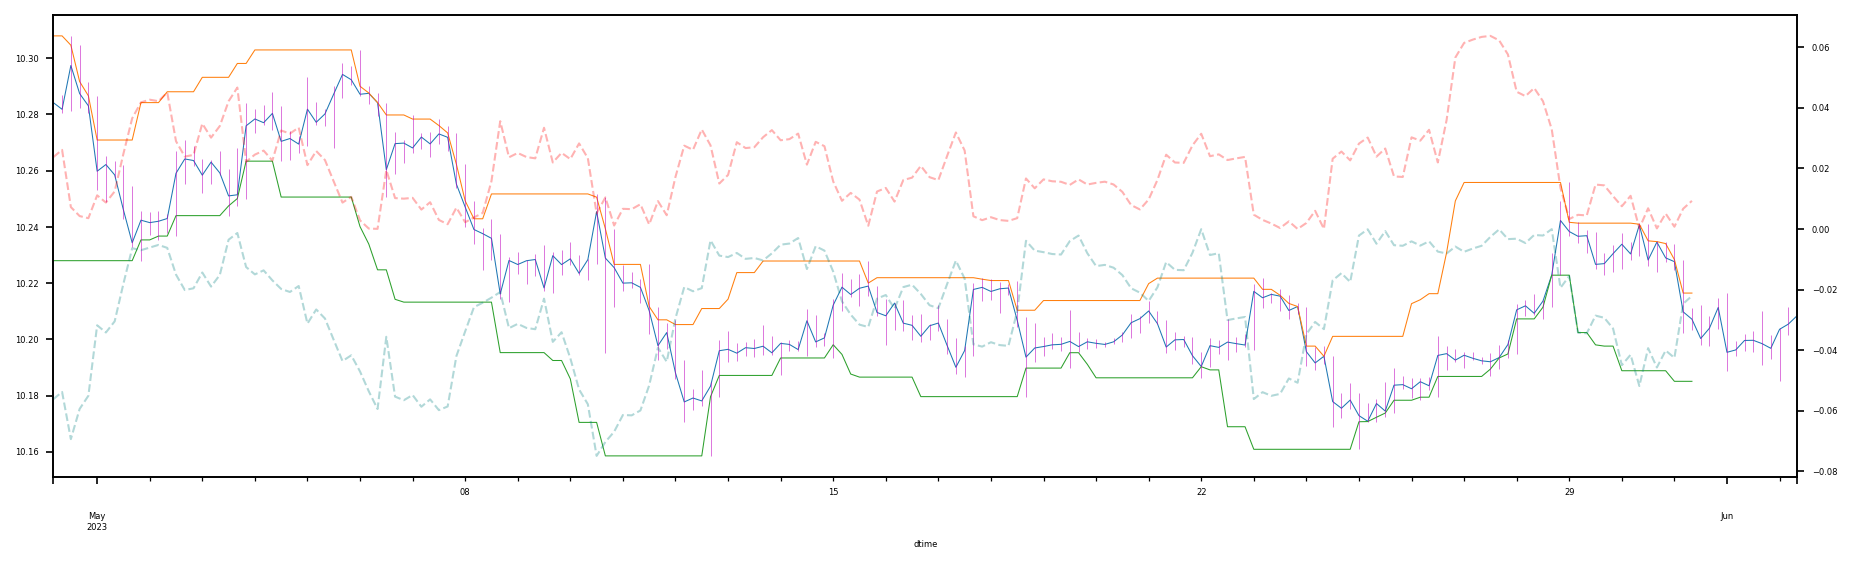

In [84]:
wdf = ldf[-200:]

fig = plt.figure(figsize=(15,4))

ax = wdf.close.plot()
wdf.fu_high.plot(ax=ax)
wdf.fu_low.plot(ax=ax)
ax.vlines(wdf.index, wdf.low, wdf.high, lw=0.25, color='m')

secax = ax.twinx()
wdf.fu_high_pct.plot(ax=secax, lw=1, linestyle='--', alpha=0.3, color='red')
wdf.fu_low_pct.plot(ax=secax, lw=1, linestyle='--', alpha=0.3, color='teal')

In [118]:
from pandas.api.types import CategoricalDtype

zdf = pd.melt(ldf, value_vars=['open', 'high', 'low', 'close'], ignore_index=False).sort_values(by=['dtime', 'variable'])

zdf
cat_ohlc = CategoricalDtype(
    ['open', 'high', 'low', 'close'], 
    ordered=True
)
zdf['variable'] = zdf.variable.astype(cat_ohlc)
zdf.sort_values(['dtime', 'variable'], inplace=True)
zdf = zdf.join(ldf.cat_fu).dropna()
zdf

,variable,value,cat_fu
dtime,,,
2017-08-17 04:00:00,open,8.357372,-0.0641__0.035
2017-08-17 04:00:00,high,8.377929,-0.0641__0.035
2017-08-17 04:00:00,low,8.357334,-0.0641__0.035
2017-08-17 04:00:00,close,8.377929,-0.0641__0.035
2017-08-17 08:00:00,open,8.374089,-0.0641__0.0203
...,...,...,...
2023-05-31 04:00:00,close,10.209791,-0.0205__0.00982
2023-05-31 08:00:00,open,10.209792,-0.0205__0.00982
2023-05-31 08:00:00,high,10.211109,-0.0205__0.00982


<Axes: >

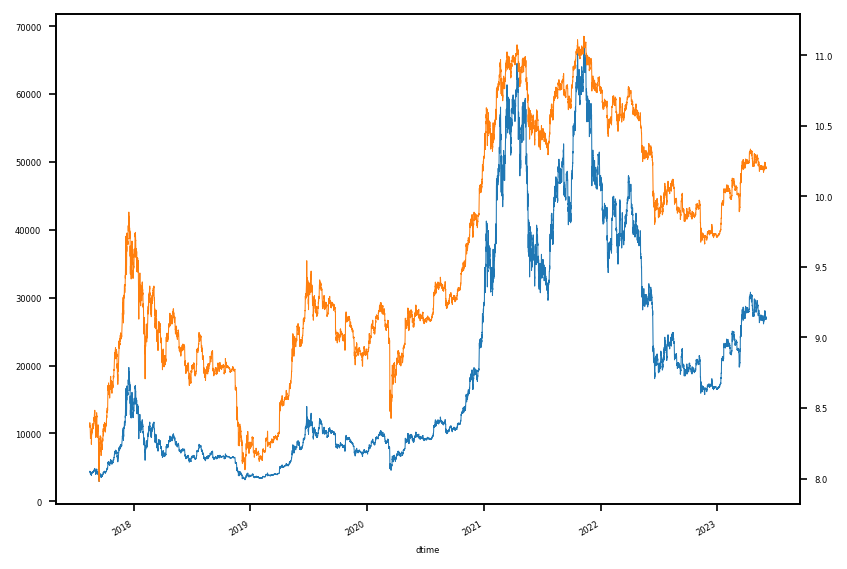

In [6]:
ax1 = odf.close.plot()
ldf.close.plot(ax=ax1, secondary_y=True)

In [34]:
l = 14
# np.split(odf.close[- (odf.shape[0] // l * l):] ,l)
X_train = to_time_series_dataset(np.split(odf.close[- (odf.shape[0] // l * l):] ,l))

In [7]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMinMax

In [109]:
ldf.join()

,open,high,low,close,fu_high,fu_low,fu_high_pct,fu_low_pct,cat_low_pct,cat_high_pct,cat_low_rbound,cat_high_rbound,cat_fu
dtime,,,,,,,,,,,,,
2017-08-17 04:00:00,8.357372,8.377929,8.357334,8.377929,8.408581,8.277211,0.030652,-0.100718,"(-0.742, -0.0641]","(0.0203, 0.035]",-0.0641,0.03500,-0.0641__0.035
2017-08-17 08:00:00,8.374089,8.408581,8.374089,8.395545,8.408581,8.255828,0.013036,-0.139717,"(-0.742, -0.0641]","(0.00982, 0.0203]",-0.0641,0.02030,-0.0641__0.0203
2017-08-17 12:00:00,8.397522,8.408581,8.374112,8.378469,8.382866,8.255828,0.004397,-0.122640,"(-0.742, -0.0641]","(-0.00144, 0.00982]",-0.0641,0.00982,-0.0641__0.00982
2017-08-17 16:00:00,8.378467,8.379043,8.343016,8.372221,8.382866,8.255828,0.010645,-0.116392,"(-0.742, -0.0641]","(0.00982, 0.0203]",-0.0641,0.02030,-0.0641__0.0203
2017-08-17 20:00:00,8.368127,8.382447,8.356686,8.362895,8.382866,8.255828,0.019972,-0.107066,"(-0.742, -0.0641]","(0.00982, 0.0203]",-0.0641,0.02030,-0.0641__0.0203
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01 16:00:00,10.199676,10.210053,10.190770,10.198493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan__nan
2023-06-01 20:00:00,10.198493,10.201478,10.192918,10.196826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan__nan
2023-06-02 00:00:00,10.196826,10.204222,10.185089,10.203592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan__nan


In [12]:
# X = to_time_series_dataset(xdf[['close','low','high']].values.T)
# X_scaled = TimeSeriesScalerMinMax().fit_transform(X)
# X_scaled[:5]

array([[[0.02350761],
        [0.02103598],
        [0.02171899],
        ...,
        [0.73529991],
        [0.73875671],
        [0.74440316]],

       [[0.02973527],
        [0.03092821],
        [0.03202265],
        ...,
        [0.71081541],
        [0.7416375 ],
        [0.74857177]],

       [[0.01836491],
        [0.01753416],
        [0.01890952],
        ...,
        [0.72471992],
        [0.73826621],
        [0.73619764]]])

Euclidean k-means
0.000 --> 0.000 --> 
DBA k-means
Init 1
0.000 --> 0.000 --> 
Init 2
0.000 --> 0.000 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


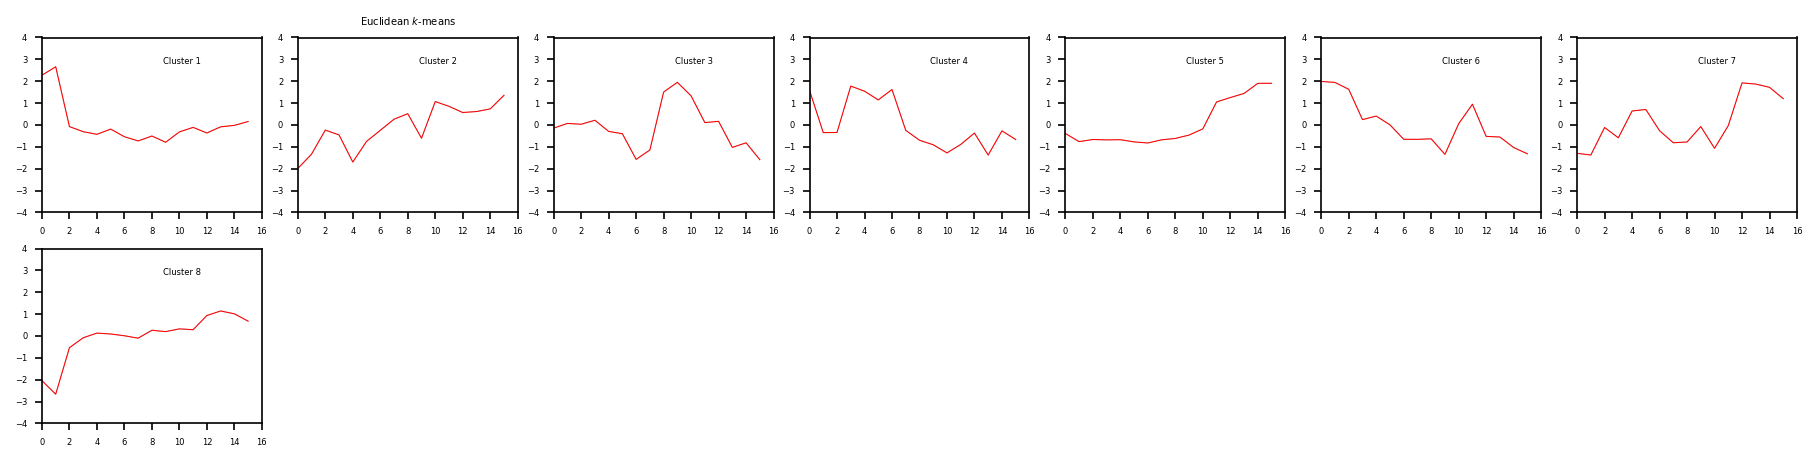

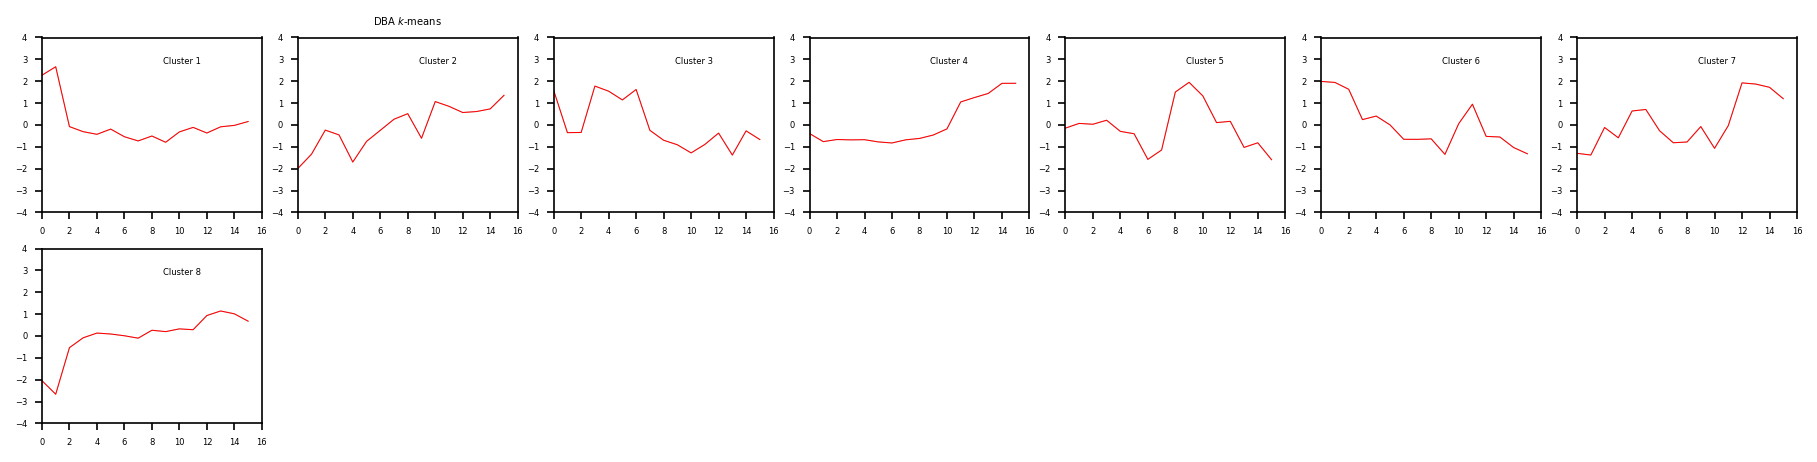

In [119]:

import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

xdf = zdf.iloc[-4 * 2000:]
# wdf.columns = ['close']
seed = 0
numpy.random.seed(seed)
# X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# X_train = X_train[y_train < 4]  # Keep first 3 classes
# X_train = to_time_series_dataset(odf[['close']].values.T)
l = 4 * 2
n_clusters = 8
X_train = to_time_series_dataset(np.split(xdf.value[- (xdf.shape[0] // l * l):] ,l))
numpy.random.shuffle(X_train)
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
# Make time series shorter
X_train = TimeSeriesResampler(sz=l*2).fit_transform(X_train)
sz = X_train.shape[1]

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)


ppl = 7
ppc = (n_clusters // ppl + 1) 
pr = ppc * 3

plt.figure(figsize=(12,3))

for yi in range(n_clusters):
    plt.subplot(ppc , ppl, yi + 1 )
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
plt.tight_layout()

# DBA-k-means
plt.figure(figsize=(12,3))
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(n_clusters):
    # plt.subplot(3, 3, 4 + yi)
    plt.subplot(ppc , ppl, yi + 1 )
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
plt.tight_layout()

# # Soft-DTW-k-means
# plt.figure(figsize=(12,3))
# print("Soft-DTW k-means")
# sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
#                            metric="softdtw",
#                            metric_params={"gamma": .01},
#                            verbose=True,
#                            random_state=seed)
# y_pred = sdtw_km.fit_predict(X_train)

# for yi in range(n_clusters):
#     plt.subplot(ppc , ppl, yi + 1 )
#     for xx in X_train[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
#     plt.ylim(-4, 4)
#     plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
#              transform=plt.gca().transAxes)
#     if yi == 1:
#         plt.title("Soft-DTW $k$-means")

# plt.tight_layout()


plt.show()

## Learning Shapelets


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Correct classification rate: 0.18666666666666668


/tmp/ipykernel_416142/2980761320.py:60: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([0, max(shapelet_sizes.keys()) - 1])


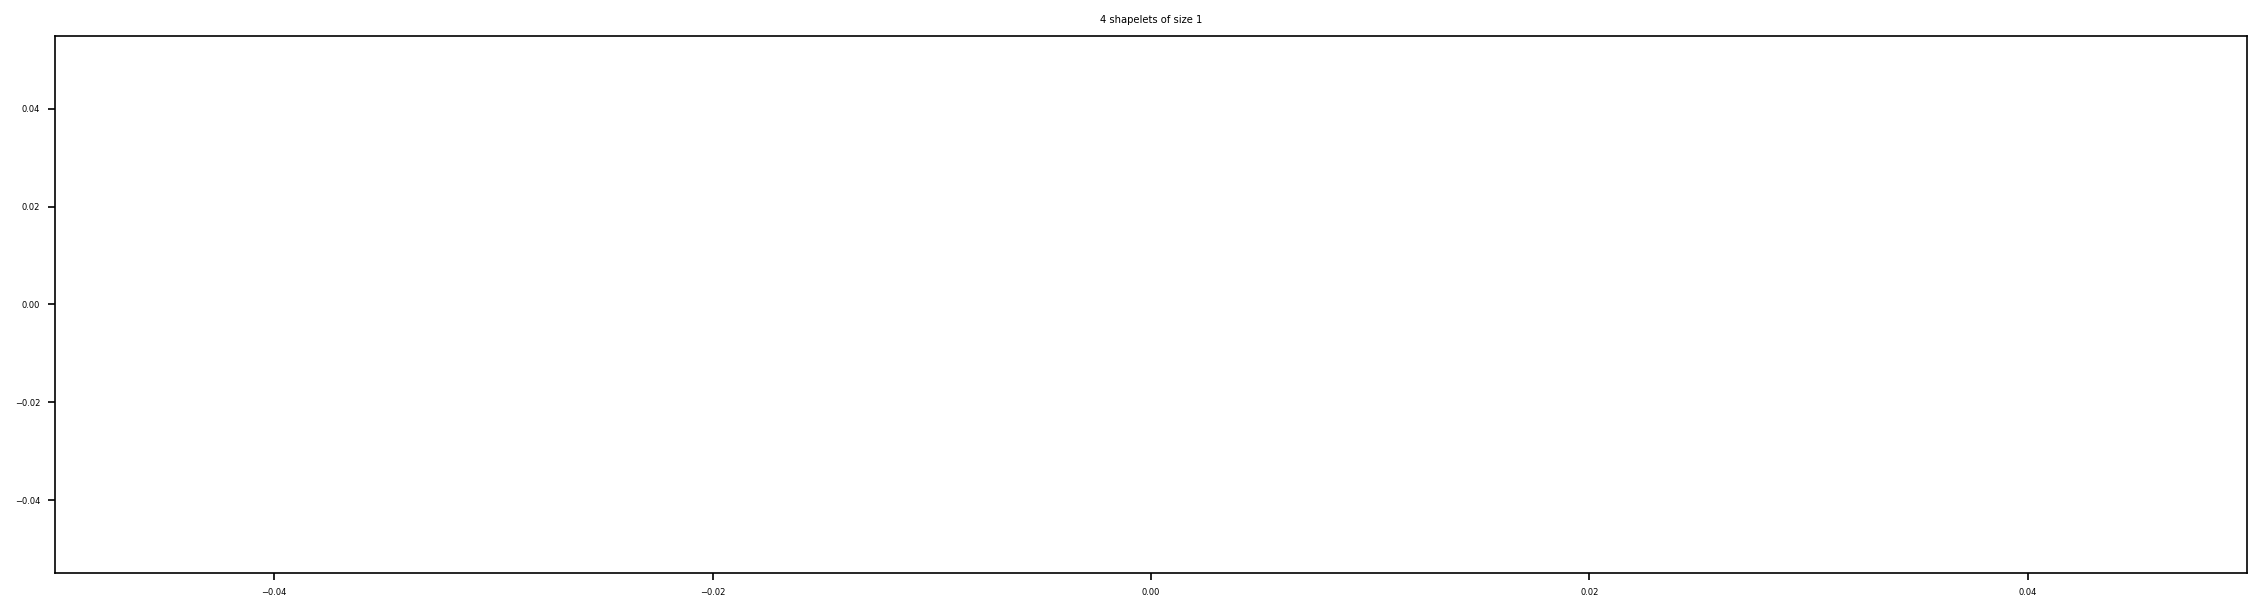

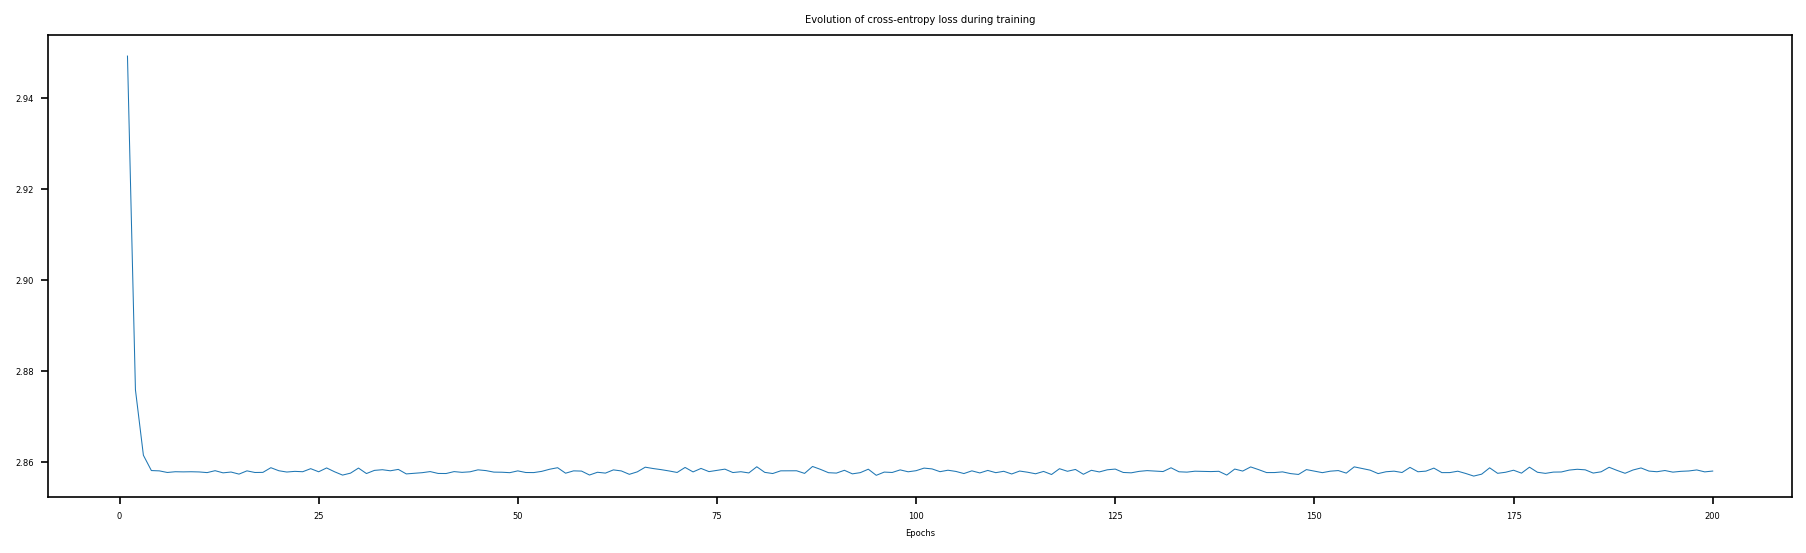

In [150]:
# Author: Romain Tavenard
# License: BSD 3 clause

import numpy
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets , grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size, to_time_series, to_time_series

# Set seed for determinism
numpy.random.seed(0)
xdf = zdf[-4*500:]
# Load the Trace dataset
X_train, X_test, y_train, y_test = train_test_split(xdf.value, xdf.cat_fu.values, train_size=0.7, shuffle=False)

X_train = to_time_series(X_train.values)
X_test = to_time_series(X_test.values)
# Normalize each of the timeseries in the Trace dataset
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=200,
                            random_state=42,
                            verbose=0)
shp_clf.fit(X_train, y_train)

# Make predictions and calculate accuracy score
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, pred_labels))

# Plot the different discovered shapelets
plt.figure(figsize=(15,4))
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()

# The loss history is accessible via the `model_` that is a keras model
plt.figure(figsize=(15,4))
plt.plot(numpy.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()

## Learning Shapelets: decision boundaries in 2D distance space

In [178]:

import numpy
from matplotlib import cm
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets
from tensorflow.keras.optimizers import Adam
from tslearn.utils import to_time_series_dataset, to_time_series

# Set a seed to ensure determinism
numpy.random.seed(42)

# Load the Trace dataset
xdf = zdf[-4*100:]
# Load the Trace dataset
# X_train, X_test, y_train, y_test = train_test_split(xdf.value, xdf.cat_fu.values, train_size=0.7, shuffle=False)

# X_train = to_time_series(X_train.values)
# X_test = to_time_series(X_test.values)

X_train, y_train = xdf.value.values, xdf.cat_fu.values

X_train = X_train.reshape(-1,1,1)
# X_train = to_time_series(X_train.values)

# Normalize the time series
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)

# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

# We will extract 2 shapelets and align them with the time series
shapelet_sizes = {20: 1}

# Define the model and fit it using the training data
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.0001,
                            optimizer=Adam(lr=0.01),
                            max_iter=300,
                            verbose=0,
                            scale=False,
                            random_state=42)
shp_clf.fit(X_train, y_train)

# We will plot our distances in a 2D space
distances = shp_clf.transform(X_train).reshape((-1, 2))
weights, biases = shp_clf.get_weights('classification')

# Create a grid for our two shapelets on the left and distances on the right
viridis = cm.get_cmap('viridis', 4)
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 9)
fig_ax1 = fig.add_subplot(gs[0, :2])
fig_ax2 = fig.add_subplot(gs[0, 2:4])
fig_ax3a = fig.add_subplot(gs[1, :2])
fig_ax3b = fig.add_subplot(gs[1, 2:4])
fig_ax3c = fig.add_subplot(gs[2, :2])
fig_ax3d = fig.add_subplot(gs[2, 2:4])
fig_ax4 = fig.add_subplot(gs[:, 4:])

# Plot our two shapelets on the left side
fig_ax1.plot(shp_clf.shapelets_[0])
fig_ax1.set_title('Shapelet $\mathbf{s}_1$')

fig_ax2.plot(shp_clf.shapelets_[1])
fig_ax2.set_title('Shapelet $\mathbf{s}_2$')

# Create the time series of each class
for i, subfig in enumerate([fig_ax3a, fig_ax3b, fig_ax3c, fig_ax3d]):
    for k, ts in enumerate(X_train[y_train == i + 1]):
        subfig.plot(ts.flatten(), c=viridis(i / 3), alpha=0.25)
        subfig.set_title('Class {}'.format(i + 1))
fig.text(x=.15, y=.02, s='Input time series', fontsize=12)

# Create a scatter plot of the 2D distances for the time series of each class.
for i, y in enumerate(numpy.unique(y_train)):
    fig_ax4.scatter(distances[y_train == y][:, 0],
                    distances[y_train == y][:, 1],
                    c=[viridis(i / 3)] * numpy.sum(y_train == y),
                    edgecolors='k',
                    label='Class {}'.format(y))

# Create a meshgrid of the decision boundaries
xmin = numpy.min(distances[:, 0]) - 0.1
xmax = numpy.max(distances[:, 0]) + 0.1
ymin = numpy.min(distances[:, 1]) - 0.1
ymax = numpy.max(distances[:, 1]) + 0.1
xx, yy = numpy.meshgrid(numpy.arange(xmin, xmax, (xmax - xmin)/200),
                        numpy.arange(ymin, ymax, (ymax - ymin)/200))
Z = []
for x, y in numpy.c_[xx.ravel(), yy.ravel()]:
    Z.append(numpy.argmax([biases[i] + weights[0][i]*x + weights[1][i]*y
                           for i in range(4)]))
Z = numpy.array(Z).reshape(xx.shape)
cs = fig_ax4.contourf(xx, yy, Z / 3, cmap=viridis, alpha=0.25)

fig_ax4.legend()
fig_ax4.set_xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
fig_ax4.set_ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
fig_ax4.set_xlim((xmin, xmax))
fig_ax4.set_ylim((ymin, ymax))
fig_ax4.set_title('Distance transformed time series')
plt.show()

/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


ValueError: Sizes in X do not match maximum shapelet size: there is at least one series in X that is shorter than one of the shapelets. Shortest time series is of length 1 and longest shapelet is of length 20

In [173]:
xdf = zdf[-4*500:]
# Load the Trace dataset
# X_train, X_test, y_train, y_test = train_test_split(xdf.value, xdf.cat_fu.values, train_size=0.7, shuffle=False)

# X_train = to_time_series(X_train.values)
# X_test = to_time_series(X_test.values)

X_train, y_train = xdf.value.values, xdf.cat_fu.values
X_train = X_train.reshape(-1,1,1)
# X_train = to_time_series(X_train.values)
X_train.shape

(2000, 1, 1)

In [166]:

X_train, y_train, _, _ = CachedDatasets().load_dataset("Trace")
X_train

array([[[ 0.54407],
        [ 0.65786],
        [ 0.61124],
        ...,
        [ 0.60377],
        [ 0.59633],
        [ 0.58322]],

       [[ 0.76643],
        [ 0.62463],
        [ 0.74225],
        ...,
        [ 0.72218],
        [ 0.66786],
        [ 0.72445]],

       [[-2.045  ],
        [-2.0917 ],
        [-2.0776 ],
        ...,
        [ 0.52429],
        [ 0.54742],
        [ 0.57056]],

       ...,

       [[-1.2657 ],
        [-1.2381 ],
        [-1.2569 ],
        ...,
        [ 0.90231],
        [ 0.87317],
        [ 0.84577]],

       [[ 0.67424],
        [ 0.6995 ],
        [ 0.72477],
        ...,
        [ 0.68093],
        [ 0.61272],
        [ 0.6502 ]],

       [[ 0.76816],
        [ 0.71678],
        [ 0.76064],
        ...,
        [ 0.76741],
        [ 0.75562],
        [ 0.67906]]])